# Bifurcating example

*You are seeing the
notebook output generated by
[Literate.jl](https://github.com/fredrikekre/Literate.jl) from the
[Julia source file](<unknown>/examples/data_bifurcating/script.jl).
The rendered HTML can be viewed [in the docs](https://juliaoptimaltransport.github.io/OptimalTransport.jl/dev/examples/data_bifurcating/).*

## Loading required packages
Load locaTE.jl and other required packages

In [1]:
using NPZ
using NNlib
using OptimalTransport
using StatsBase
using SparseArrays
using LinearAlgebra
using Plots
using LaTeXStrings
using Graphs
using GraphSignals
using NearestNeighbors
using ProgressMeter
using Discretizers
import locaTE as lTE;
using Suppressor

## Load expression values from BoolODE simulation output.
We set small expression values to zero -- these are artifacts of simulation, since they are generated
using a chemical Langevin equation approximation. Alternatively, one could just use constant-width bins
for the discretizer or simulate data from a more involved Gillespie scheme.

In [2]:
cd("../../../examples/data_bifurcating")
X = relu.(npzread("X.npy") .- 10^(-0.5));
X_pca = npzread("X_pca.npy")
X_tsne = npzread("X_tsne.npy")
P = npzread("P_velo_dot.npy")
dpt = npzread("dpt.npy")
C = npzread("C.npy")
J = permutedims(npzread("J.npy"), [1, 3, 2]);
id = npzread("clusterid.npy");

construct neighbourhoods using QOT

In [3]:
R = quadreg(ones(size(X, 1)), ones(size(X, 1)), C, 2.5 * mean(C));

list of gene pairs

In [4]:
gene_idxs = vcat([[j, i]' for i = 1:size(X, 2) for j = 1:size(X, 2)]...);

## Construct sparse forward and backward transition matrices for `k` steps of `P`.

In [5]:
k = 3
π_unif = fill(1 / size(P, 1), size(P, 1))'
Q = (P' .* π_unif) ./ (π_unif * P)';
R_sp = sparse(R)
QT_sp = sparse((Q^k)')
P_sp = sparse((P^k));

plot forward/backward for a selected cell

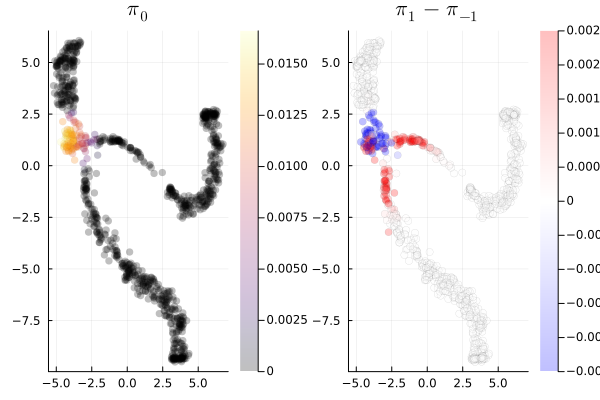

In [6]:
p0 = R[sortperm(dpt)[250], :]
plot(
    scatter(
        X_tsne[:, 1],
        X_tsne[:, 2];
        marker_z = p0,
        markerstrokewidth = 0,
        alpha = 0.25,
        title = L"π_0",
    ),
    scatter(
        X_tsne[:, 1],
        X_tsne[:, 2];
        marker_z = P_sp' * p0 - p0,
        color = :bwr,
        clim = (-0.0025, 0.0025),
        markerstrokewidth = 0.25,
        alpha = 0.25,
        title = L"π_{1} - π_{-1}",
    );
    legend = nothing,
)

## Construct kNN and Laplacian

In [7]:
kdtree = KDTree(X_pca')
idxs, dists = knn(kdtree, X_pca', 25);
A = spzeros(size(X_pca, 1), size(X_pca, 1));
for (i, j) in enumerate(idxs)
    A[i, j] .= 1.0
end
L = sparse(normalized_laplacian(max.(A, A'), Float64));

## Perform directed inference

In [8]:
using Base.Threads
@info "Directed inference"
mi_all = zeros(size(X, 1), size(X, 2)^2);
@info "Computing TE scores"
alg = DiscretizeBayesianBlocks()
disc = lTE.discretizations_bulk(X; alg = alg)
@threads for i = 1:size(X, 1)
    mi_all[i, :] = lTE.get_MI(
        X,
        lTE.compute_coupling(X, i, P_sp, QT_sp, R_sp),
        gene_idxs[:, 1],
        gene_idxs[:, 2];
        disc = disc,
        alg = alg,
    )
end
@info "Applying CLR"
mi_all_clr = lTE.apply_wclr(mi_all, size(X, 2))
mi_all_clr[isnan.(mi_all_clr)] .= 0;

[ Info: Directed inference
[ Info: Computing TE scores
[ Info: Applying CLR


## Denoise using graph-regularized regression

In [9]:
@info "Denoising"
w = normalize(vec(sqrt.(sum(mi_all_clr .^ 2; dims = 2))), 1) # weights (optional)
G = @suppress lTE.fitsp(mi_all_clr, L; λ1 = 25.0, λ2 = 0.001, maxiter = 500);
G_symm = lTE.symm_row(G, size(X, 2)); # symmetrized version for comparison to undirected methods

[ Info: Denoising
[ Info: ΔX = 4.1909887840729695e-8, ΔZ = 9.309533274094034e-6, ΔW = 1.773125608785925e-5
[ Info: tr(X'LX) = 0.18907466432957898, 0.5|X-G|^2 = 1.462485242920526, |X|1 = 397.92116530117215


we can plot the TE density

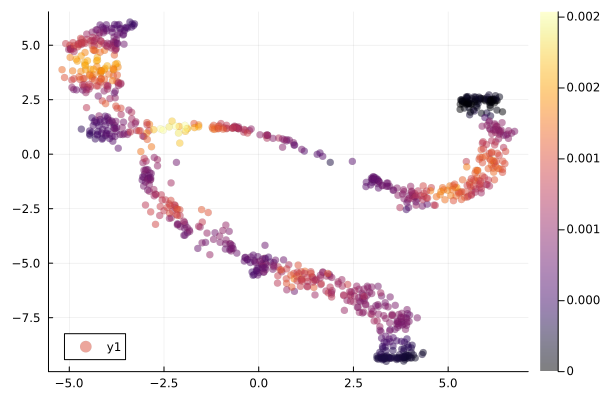

In [10]:
scatter(
    X_tsne[:, 1],
    X_tsne[:, 2];
    marker_z = w,
    markerstrokewidth = 0,
    clim = (0, quantile(w, 0.995)),
    alpha = 0.5,
)

Interaction by cell

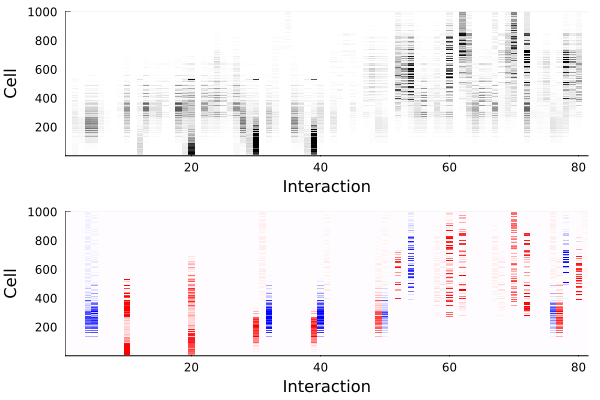

In [11]:
plt = plot(
    heatmap(
        G[sortperm(dpt), :];
        xlabel = "Interaction",
        ylabel = "Cell",
        c = cgrad([:white, :black]),
        clim = (0, quantile(vec(G), 0.995)),
    ),
    heatmap(
        (R*reshape(J, :, size(X, 2)^2))[sortperm(dpt), :],
        c = :bwr,
        clim = (-1.5, 1.5);
        xlabel = "Interaction",
        ylabel = "Cell",
    ),
    colorbar = nothing,
    layout = (2, 1),
)
plt

## ROC and PR curves

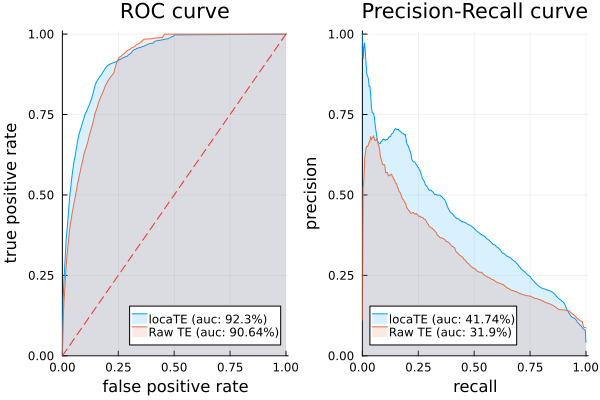

In [12]:
using EvalMetrics
plt1 = rocplot(
    vec(R * reshape(abs.(J), :, size(X, 2) * size(X, 2))) .> 0.5,
    vec(G);
    label = "locaTE",
);
rocplot!(
    vec(R * reshape(abs.(J), :, size(X, 2) * size(X, 2))) .> 0.5,
    vec(mi_all);
    label = "Raw TE",
);
plt2 = prplot(
    vec(R * reshape(abs.(J), :, size(X, 2) * size(X, 2))) .> 0.5,
    vec(G);
    label = "locaTE",
);
prplot!(
    vec(R * reshape(abs.(J), :, size(X, 2) * size(X, 2))) .> 0.5,
    vec(mi_all);
    label = "Raw TE",
);
plot(plt1, plt2)

## Plot averaged interactions by cluster

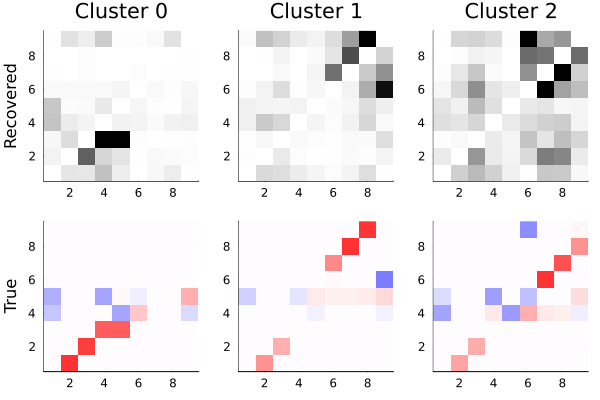

In [13]:
plt1 = plot(
    [
        heatmap(
            normalize(reshape(mean(G[id.==i, :]; dims = 1), size(X, 2), size(X, 2)), Inf),
            c = cgrad([:white, :black]),
            title = "Cluster $i",
            clim = (0, 0.75),
            ylabel = i == 0 ? "Recovered" : "",
        ) for i in sort(unique(id))
    ]...;
    layout = (1, 3),
    colorbar = nothing,
)
plt2 = plot(
    [
        heatmap(
            normalize(mean(J[id.==i, :, :]; dims = 1)[1, :, :], Inf);
            c = :bwr,
            clim = (-1.25, 1.25),
            ylabel = i == 0 ? "True" : "",
        ) for i in sort(unique(id))
    ]...;
    layout = (1, 3),
    colorbar = nothing,
)
plt = plot(plt1, plt2; layout = (2, 1))
plt

## Factor analysis with NMF

In [14]:
qnorm(x, q) = x ./ quantile(vec(x), q)
Cg = cor(X) .^ 2;
Cg[diagind(Cg)] .= 0;
U, V, trace = @suppress lTE.fitnmf(
    relu.(qnorm(mi_all_clr, 0.9)),
    [I(size(G, 1)), I(size(G, 2))],
    1e-3 * I + L,
    repeat(vec(Cg), 1, size(X, 1))',
    8;
    α = 25.0,
    β = 0.0,
    λ = [10.0, 10.0],
    μ = [10.0, 10.0],
    iter = 2_500,
    initialize = :nmf,
    print_iter = 500,
    dictionary = false,
    η = 1.0,
);
G_nmf = U * V';
U .*= mean(V; dims = 1)
V ./= mean(V; dims = 1);

[ Info: Initializing NMF decomposition with nmf


Plot coefficients and atoms

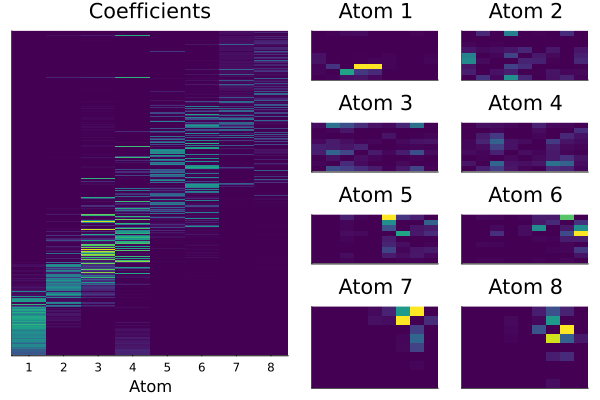

In [15]:
perm = sortperm(vec(sum((U ./ sum(U; dims = 1)) .* dpt; dims = 1))) # sort atoms by order of activation
plt1 = heatmap(
    U[sortperm(dpt), perm],
    colorbar = nothing,
    yaxis = nothing,
    title = "Coefficients",
    xticks = (1:size(U, 2)),
    xlabel = "Atom",
    c = :viridis,
);
plt2 = plot(
    [
        heatmap(
            reshape(v, size(X, 2), size(X, 2));
            title = "Atom $i",
            axis = nothing,
            clim = (0, quantile(vec(V), 0.99)),
            c = :viridis,
        ) for (i, v) in enumerate(eachcol(V[:, perm]))
    ]...;
    colorbar = nothing,
    layout = (4, 2),
);
plot(plt1, plt2)

## Factor analysis with NTF

In [16]:
using TensorToolbox
Cg = cor(X) .^ 2;
Cg[diagind(Cg)] .= 0;
S, A, trace = @suppress lTE.fitntf(
    Array(reshape(qnorm(mi_all_clr, 0.9), :, size(X, 2), size(X, 2))),
    [I(size(X, 1)), I(size(X, 2)), I(size(X, 2))],
    1e-3 * I + L,
    repeat(reshape(Cg, 1, size(X, 2), size(X, 2)), size(X, 1)),
    [1, 1, 1],
    [1, 1, 1],
    25.0,
    0.0,
    16;
    iter = 500,
    dictionary = false,
    η = 1.0,
);
G_ntf = reshape(ttm(S, A, 1:length(A)), :, size(X, 2)^2);
ntf_atoms = [x * y' for (x, y) in zip(eachcol(A[2]), eachcol(A[3]))];
A[1] .*= mean.(ntf_atoms)'
A[2] ./= sqrt.(mean.(ntf_atoms))'
A[3] ./= sqrt.(mean.(ntf_atoms))'
ntf_atoms ./= mean.(ntf_atoms);

cluster atoms

In [17]:
using Clustering
hc = hclust(1 .- cor(A[1]))
clusts = cutree(hc; k = 8)
ntf_atoms_clust_activity =
    hcat([sum(A[1][:, clusts.==i]; dims = 2) for i = 1:length(unique(clusts))]...)
ntf_atoms_clust = [sum(ntf_atoms[clusts.==i]) for i = 1:length(unique(clusts))];
ntf_atoms_clust_nums = [sum(clusts .== i) for i = 1:length(unique(clusts))];
perm_clust = sortperm(
    vec(
        sum(
            (ntf_atoms_clust_activity ./ sum(ntf_atoms_clust_activity; dims = 1)) .* dpt;
            dims = 1,
        ),
    ),
)
perm = sortperm(vec(sum((A[1] ./ sum(A[1]; dims = 1)) .* dpt; dims = 1)));

Plot coefficients and atoms

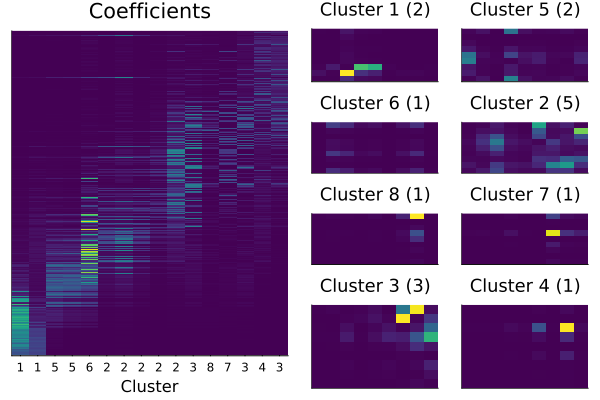

In [18]:
plt2 = plot(
    [
        heatmap(
            x;
            title = "Cluster $(perm_clust[i]) ($(ntf_atoms_clust_nums[perm_clust[i]]))",
            axis = nothing,
            titlefontsize = 12,
            clim = (0, quantile(vec(hcat(ntf_atoms...)), 0.999)),
            c = :viridis,
        ) for (i, x) in enumerate(ntf_atoms_clust[perm_clust])
    ]...;
    colorbar = nothing,
    layout = (4, 2),
);
plt1 = heatmap(
    A[1][sortperm(dpt), perm],
    colorbar = nothing,
    yaxis = nothing,
    title = "Coefficients",
    xticks = (1:size(A[1], 2), clusts[perm]),
    xlabel = "Cluster",
    c = :viridis,
);
plot(plt1, plt2)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*